In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.tools.plotting import lag_plot
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import pystan

In [3]:
def month_string_to_number(string):
    """ month_string_to_number takes a month and turns it into the 
    corresponding number
    args:
        :string - each item is a string

    returns:
        :(out) - the equivalent of the month's number
    """
    m = {
        'jan': 1,
        'feb': 2,
        'mar': 3,
        'apr':4,
         'may':5,
         'jun':6,
         'jul':7,
         'aug':8,
         'sep':9,
         'oct':10,
         'nov':11,
         'dec':12
        }
    s = string.strip()[:3].lower()

    try:
        out = m[s]
        return out
    except:
        raise ValueError('Not a month')
        
path = '/Users/afugere/Desktop/UVM Masters/GraduateSemester2/STAT330/FinalProject/'
path2 = '/Users/abigailhotaling/Documents/STAT_330_Project/Data/'
data = pd.read_csv(path+ 'Electricity_Residential_Price_New_England.csv')

#data.columns = ['Date', 'Electricity Residential Price: New England cents per kilowatthour']
data.columns = ['Date', 'Electricity Price']
# I also changed the column name for now, just to be a little bit shorter 
dates = []
months = []
years = []
for entry in data['Date']:
    dates.append(entry.replace('-', ' '))
    data['Month and Year'] = pd.Series(dates)
    months.append(month_string_to_number(str(entry[0:-3])))
    years.append(entry[-2:])
    data['Month'] = pd.Series(months)
    data['Year'] = pd.Series(years)
    
updated_years = []
for y in data['Year']:
    if int(y) > 19:
        updated_years.append('19'+y)
    else:
        updated_years.append('20'+y)
    data['Year'] = pd.Series(updated_years)
    
data['Day'] = [1]*len(data)

data['Datetime'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
data.iloc[:] = data.iloc[::-1].values

In [58]:
def plot_trace(param, param_name='parameter'):
  """Plot the trace and posterior of a parameter."""
  
  # Summary statistics
  mean = np.mean(param)
  median = np.median(param)
  cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
  
  # Plotting
  plt.subplot(2,1,1)
  plt.plot(param)
  plt.xlabel('samples')
  plt.ylabel(param_name)
  plt.axhline(mean, color='r', lw=2, linestyle='--')
  plt.axhline(median, color='c', lw=2, linestyle='--')
  plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
  plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
  plt.title('Trace and Posterior Distribution for {}'.format(param_name))

  plt.subplot(2,1,2)
  plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
  plt.xlabel(param_name)
  plt.ylabel('density')
  plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
  plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
  plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
  plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
  plt.gcf().tight_layout()
  plt.legend()

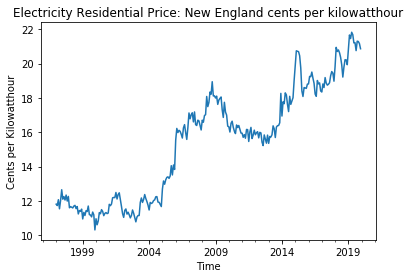

In [4]:
ax = data.plot(x = 'Datetime', y = 'Electricity Price', 
               title = 'Electricity Residential Price: New England cents per kilowatthour', legend = False)
ax.set_xlabel('Time')
ax.set_ylabel('Cents per Kilowatthour')
ax.format_xdata = mdates.DateFormatter('%Y-%m')

Model 1:

AR(2)

p=2 (number of lags)

$y_t = \alpha + \phi_1 y_{t-1} + \phi_2 y_{t-2}+\epsilon_t$

$\epsilon_t \sim N(0, \sigma^2)$

Need to estimate posterior for $\sigma^2$, $\phi_i$, $\alpha$ for $i=1, ...,2$ 

Priors: 

$\alpha \sim N(0, 1)$

$\phi_i \sim N(0, 1)$ for i in $i=1, ...,p$

$\sigma^2 \sim \Gamma^{-1}(a, b)$

Arbitrarily choose $a$ and $b$

Higher values of $b$ would give a wider distribution. And $a=b=1$ is an uniformitive prior. 

In [5]:
m1_stan_code = """
data {

    int T; // number of time steps
    int K; // Number of time series
    int P; // Number of lags for AR element
    
    matrix[T, K] Y; // data to model
        
    // priors
    real alpha_prior_location;
    real alpha_prior_scale;
    
    real sigma_prior_location;
    real sigma_prior_scale;
    
    real phi_prior_location;
    real phi_prior_scale;
    
}

transformed data{
    matrix[T,P] Y_lagged[K];
        
    for (k in 1:K){
        Y_lagged[k] = rep_matrix(0,T,P);
        for (p in 1:P){
            Y_lagged[k, p+1:T,p] = Y[1:T-p,k];
        }
    } 
}

parameters {
    vector[K] alpha; //intercept
    vector<lower=0>[K] sigma;
    matrix[K,P] phi; //lag parameters
}


model {
    matrix[T,K] err;
    matrix[T,K] nu;
    
    alpha ~ normal(alpha_prior_location, alpha_prior_scale);
    //sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    sigma ~ inv_gamma(sigma_prior_location, sigma_prior_scale);
    if (P>0){
    for (p in 1:P){
        phi[:,p] ~ normal(phi_prior_location, phi_prior_scale);
    }
    }
    
    
    for (k in 1:K) {
        nu[:,k] = rep_vector(alpha[k], T);
        if (P>0){
            nu[:,k] = nu[:,k] + Y_lagged[k]*phi[k]';
        }
    }
    
    err = Y - nu;
    
    for (k in 1:K){
        err[P+1:T,k] ~ normal(0, sigma[k]);
    }
}"""

In [7]:
m1_data = {'T':len(data), 'K':1, 'P':2, 'Y':np.asarray(list(data['Electricity Price'])).reshape(len(data), 1),
           "alpha_prior_location": 0, 'alpha_prior_scale':1, 'sigma_prior_location': 1, 'sigma_prior_scale':1, 
           'phi_prior_location':0, 'phi_prior_scale':1}


In [69]:
fit = pystan.stan(model_code=m1_stan_code, data=m1_data, iter=2000, warmup = 100, chains=3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_29faab67f95b545bed2e8a33d36fba9d NOW.
/Users/afugere/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [9]:
print(fit)

Inference for Stan model: anon_model_29faab67f95b545bed2e8a33d36fba9d.
3 chains, each with iter=1000; warmup=100; thin=1; 
post-warmup draws per chain=900, total post-warmup draws=2700.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[0]    0.1  4.6e-3   0.12  -0.14   0.02    0.1   0.18   0.34    728    1.0
sigma[0]   0.43  3.5e-4   0.02    0.4   0.42   0.43   0.44   0.47   2668    1.0
phi[0,0]   0.84  1.8e-3   0.06   0.73    0.8   0.85   0.89   0.96   1187    1.0
phi[0,1]   0.15  1.8e-3   0.06   0.03   0.11   0.15   0.19   0.27   1161    1.0
lp__      91.68    0.04   1.38  88.17  91.01  91.98  92.71   93.4    978    1.0

Samples were drawn using NUTS at Mon Nov 19 13:00:32 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


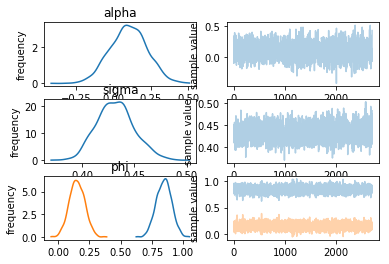

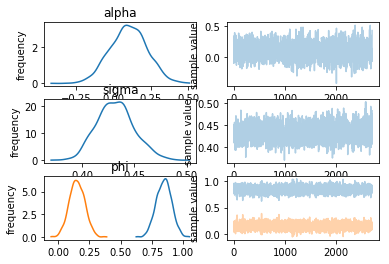

In [10]:
fit.plot()


We seem to have convergence 

[Abby to-do]

    Need to look at these results compared to frequentist methods

    Look at residuals and model diagnostics
    
    Explore different priors
   
    


In [15]:
summary_dic = fit.summary()
df = pd.DataFrame(summary_dic['summary'], columns = summary_dic['summary_colnames'], index=summary_dic['summary_rownames'])

In [19]:
df

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha[0],0.101864,0.004572,0.123354,-0.141916,0.018728,0.101450,0.184442,0.338713,728.0,1.002585
sigma[0],0.432069,0.000349,0.018014,0.400161,0.419537,0.431529,0.443243,0.469517,2668.0,1.000314
"phi[0,0]",0.844666,0.001751,0.060339,0.726737,0.802274,0.846828,0.885818,0.963059,1187.0,1.000912
"phi[0,1]",0.151195,0.001790,0.060985,0.032612,0.109007,0.150202,0.193948,0.271342,1161.0,1.000722
lp__,91.684619,0.044034,1.377073,88.166700,91.009430,91.980689,92.708704,93.395773,978.0,1.001675


In [33]:
alpha_mean, sigma_mean, df_phi_0_0_mean, df_phi_0_1_mean = df['mean']['alpha[0]'], df['mean']['sigma[0]'], df['mean']['phi[0,0]'], df['mean']['phi[0,1]']

In [45]:
alpha = fit['alpha']
sigma = fit['sigma']
phi = fit['phi']
lp = fit['lp__']

### Alternative way to Look at the Trace Plots

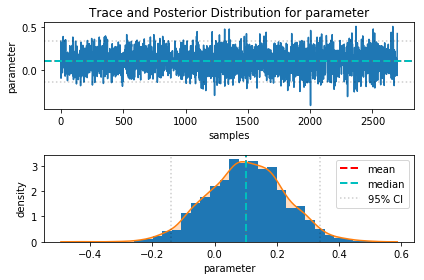

In [59]:
plot_trace(alpha)

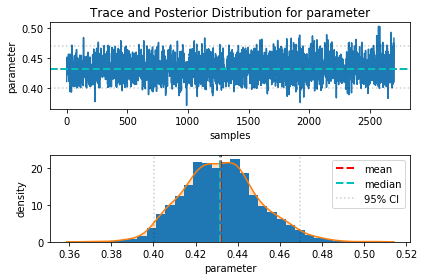

In [60]:
plot_trace(sigma)

In [62]:
## I can't get this to work for phi

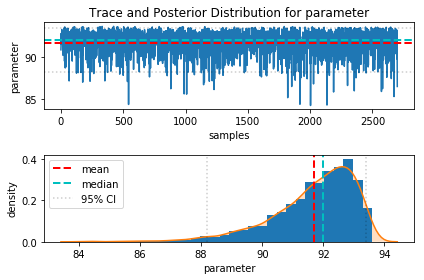

In [61]:
plot_trace(lp)